In [1]:
import os
import heapq

import ssl
import tqdm
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from IPython.display import SVG, Image
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, GlobalAveragePooling1D
from keras.optimizers import Adam
from keras.utils.vis_utils import model_to_dot
from keras.preprocessing.sequence import pad_sequences

Using TensorFlow backend.


In [2]:
ssl._create_default_https_context = ssl._create_unverified_context

# Скачаем данные и посмотрим на них

Мы будем использовать imdb, подробнее про него можно прочитать тут: https://keras.io/datasets/.

In [3]:
vocab_size = 10000

(x_train, y_train), (x_test, y_test) = imdb.load_data(path="imdb.npz",
                                                      num_words=vocab_size,
                                                      skip_top=0,
                                                      maxlen=None,
                                                      seed=113,
                                                      start_char=1,
                                                      oov_char=2,
                                                      index_from=3)

word_2_index = imdb.get_word_index()

1646592/1641221 [==============================] - 1s 1us/step


In [4]:
word_2_index = {k:(v+3) for k,v in word_2_index.items()} 
word_2_index["<PAD>"] = 0
word_2_index["<START>"] = 1
word_2_index["<UNK>"] = 2
word_2_index["<UNUSED>"] = 3

index_2_word = {value: key for key, value in word_2_index.items()}

In [5]:
print('Index "100" to word = {}'.format(index_2_word[100]))
print('Word "could" to index = {}'.format(word_2_index['could']))

Index "100" to word = could
Word "could" to index = 100


In [6]:
def decode_review(text):
    return ' '.join([index_2_word.get(i, '?') for i in text])

In [7]:
print(decode_review(x_train[0]))
print('')
print('Label = {}'.format(y_train[0]))

<START> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <UNK> is an amazing actor and now the same being director <UNK> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for <UNK> and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also <UNK> to the two little boy's that played the <UNK> of norman and paul they were just brilliant children are often left out of the <UNK> list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for wha

In [18]:
print('Decoded texts for train set')
x_train_decoded = []
for review in tqdm.tqdm_notebook(x_train):
    decoded_review = decode_review(review)
    x_train_decoded.append(decoded_review)

print('Decoded texts for test set')
x_test_decoded = []
for review in tqdm.tqdm_notebook(x_test):
    decoded_review = decode_review(review)
    x_test_decoded.append(decoded_review)

Decoded texts for train set



Decoded texts for test set


In [19]:
len(x_train_decoded)

25000

In [21]:
x_train_decoded[0]

"<START> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <UNK> is an amazing actor and now the same being director <UNK> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for <UNK> and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also <UNK> to the two little boy's that played the <UNK> of norman and paul they were just brilliant children are often left out of the <UNK> list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for wh

# Классическая обработка текстов

Для векторизации текстов воспользуемся CountVectorizer, он представляет документ как мешок слов. Можно всячески варировать извлечение признаков (убирать редкие слова, убирать частые слова, убирать слова общей лексики, брать биграмы и т.д.)

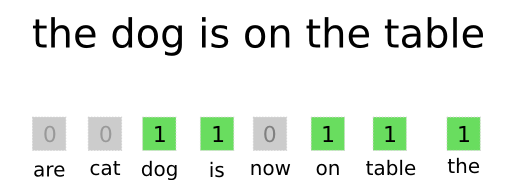

In [22]:
Image('pics/bag_of_words.png', width=600)

In [23]:
count_vectorizer = CountVectorizer(min_df=1,
                                   ngram_range=(1, 1))

Мы будем работать с эффективным представлением матриц "Compressed Sparse Row Format" (CSR). Почитать о формате можно здесь: https://en.wikipedia.org/wiki/Sparse_matrix#Compressed_sparse_row_(CSR,_CRS_or_Yale_format)

In [24]:
x_train_bow = count_vectorizer.fit_transform(x_train_decoded)
x_test_bow = count_vectorizer.transform(x_test_decoded)

In [25]:
print('Shape of train sample in BoW format', x_train_bow.shape)
print('Shape of test sample in BoW format', x_test_bow.shape)

Shape of train sample in BoW format (25000, 9772)
Shape of test sample in BoW format (25000, 9772)


In [26]:
index_2_word_logreg = {
    v: k
    for k, v in count_vectorizer.vocabulary_.items()
}

### Обучим логистическую регрессию предсказывать тональность отзыва на признаках Bag-of-Words

In [29]:
model_logreg = LogisticRegression(solver='saga', multi_class='auto')

In [30]:
model_logreg.fit(x_train_bow, y_train)

/Users/konstantinivanov/ENV/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='auto',
          n_jobs=None, penalty='l2', random_state=None, solver='saga',
          tol=0.0001, verbose=0, warm_start=False)

###  Попробуем проинтерпретировать коэффициенты модели

In [31]:
W = model_logreg.coef_.shape[1]
NUM_WORDS = 10
class_2_function = {'Negative': heapq.nsmallest, 'Positive': heapq.nlargest}

for category, function in class_2_function.items():
    topic_words = [
        index_2_word_logreg[w_num]
        for w_num in function(NUM_WORDS, range(W),
                              key=lambda w: model_logreg.coef_[0, w])
    ]
    print(category)
    print(', '.join(topic_words))

Negative
bad, worst, awful, waste, boring, poor, nothing, terrible, no, script
Positive
great, excellent, best, wonderful, perfect, well, love, fun, amazing, still


### Оценим качество

In [32]:
preds_logreg = model_logreg.predict(x_test_bow)

In [33]:
print('Train accuracy', accuracy_score(
    model_logreg.predict(x_train_bow),
    y_train
))
print('Test accuracy', accuracy_score(preds_logreg, y_test))

Train accuracy 0.86964
Test accuracy 0.854


### Попробуем TF-IDF

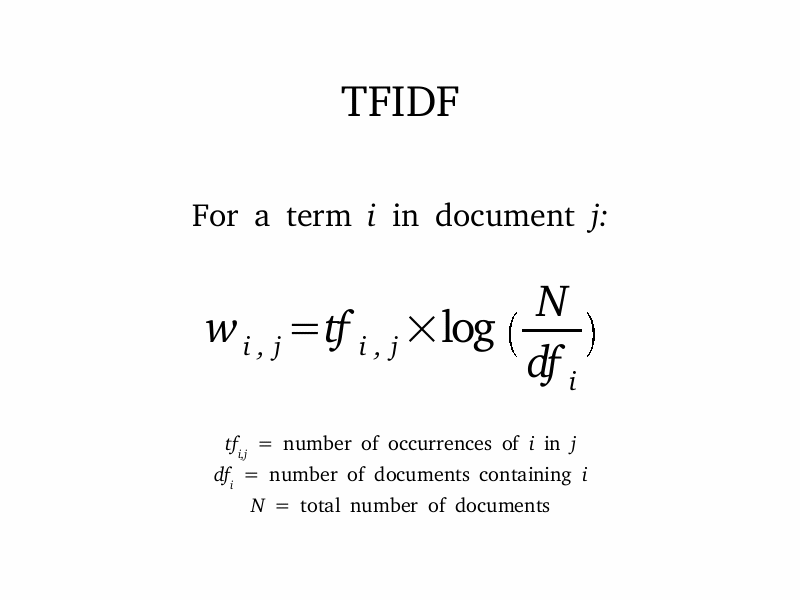

In [34]:
Image('./pics/tfidf.png')

Подробнее про tf-idf можно прочитать здесь: https://ru.wikipedia.org/wiki/TF-IDF

In [35]:
tf_idf_transformer = TfidfTransformer()

In [36]:
x_train_tfidf = tf_idf_transformer.fit_transform(x_train_bow)
x_test_tfidf = tf_idf_transformer.transform(x_test_bow)

### Обучим логистическую регрессию предсказывать тональность отзыва на признаках TF-IDF

In [37]:
model_logreg_tfidf = LogisticRegression(solver='saga', multi_class='auto')

In [38]:
model_logreg_tfidf.fit(x_train_tfidf, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='auto',
          n_jobs=None, penalty='l2', random_state=None, solver='saga',
          tol=0.0001, verbose=0, warm_start=False)

In [39]:
preds_logreg_tfidf = model_logreg_tfidf.predict(x_test_tfidf)

### Оценим качество

In [40]:
print('Train accuracy', accuracy_score(
    model_logreg_tfidf.predict(x_train_tfidf),
    y_train
))
print('Test accuracy', accuracy_score(preds_logreg_tfidf, y_test))

Train accuracy 0.92132
Test accuracy 0.88404


# Глубокое обучение в обработке текстов

Код частично взят из примеров TensorFlow: https://www.tensorflow.org/tutorials/keras/basic_text_classification

Нужно привести все тексты к одной длине, чтобы их можно было объединять в батчи для статичных графов. Неплохое сравнение динамических и статичных графов можно найти тут: https://stackoverflow.com/questions/46154189/what-is-the-difference-of-static-computational-graphs-in-tensorflow-and-dynamic.

In [42]:
x_train_decoded[0]

"<START> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <UNK> is an amazing actor and now the same being director <UNK> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for <UNK> and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also <UNK> to the two little boy's that played the <UNK> of norman and paul they were just brilliant children are often left out of the <UNK> list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for wh

In [43]:
word_2_index["<PAD>"]

0

In [44]:
x_train_pad = pad_sequences(x_train,
                            value=word_2_index["<PAD>"],
                            padding='post',
                            maxlen=256)

x_test_pad = pad_sequences(x_test,
                           value=word_2_index["<PAD>"],
                           padding='post',
                           maxlen=256)

### Определим модель и обучим ее

Модель будет очень простой, мы вставим Embedding слой, который будет давать каждому слову в тексте сжатую репрезентацию, то есть будет переводить его из размерности vocab_size в размерность 16. Далее GlobalAveragePooling1D слой будет усреднять репрезентации всех слов в тексте. На основе усредненной репрезентации маленький перцептрон будет проводить классификацию.

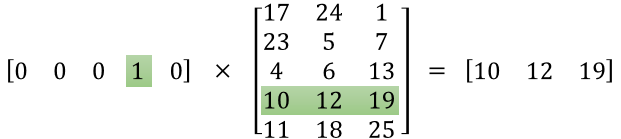

In [45]:
Image('pics/matrix_mult_w_one_hot.png')

Установим сиды, чтобы получать воспроизводимые результаты.

In [46]:
np.random.seed(2)
tf.set_random_seed(2)

In [47]:
model_dl = Sequential()
model_dl.add(Embedding(vocab_size, 16))
model_dl.add(GlobalAveragePooling1D())
model_dl.add(Dense(units=16, activation='relu'))
model_dl.add(Dropout(0.5))
model_dl.add(Dense(units=1, activation='sigmoid'))

In [48]:
model_dl.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
global_average_pooling1d_1 ( (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                272       
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 17        
Total params: 160,289
Trainable params: 160,289
Non-trainable params: 0
_________________________________________________________________


In [ ]:
SVG(model_to_dot(model_dl).create(prog='dot', format='svg'))

In [49]:
opt = Adam(lr=0.001)

model_dl.compile(optimizer=opt,
                 loss='binary_crossentropy',
                 metrics=['accuracy'])

In [50]:
history = model_dl.fit(x=x_train_pad,
                       y=y_train,
                       epochs=20,
                       batch_size=512,
                       validation_data=(x_test_pad, y_test),
                       verbose=1)

Train on 25000 samples, validate on 25000 samples
Epoch 1/20
25000/25000 [==============================] - 2s 66us/step - loss: 0.6909 - acc: 0.5697 - val_loss: 0.6870 - val_acc: 0.6778
Epoch 2/20
25000/25000 [==============================] - 1s 52us/step - loss: 0.6790 - acc: 0.6797 - val_loss: 0.6686 - val_acc: 0.7624
Epoch 3/20
25000/25000 [==============================] - 1s 47us/step - loss: 0.6491 - acc: 0.7293 - val_loss: 0.6273 - val_acc: 0.7876
Epoch 4/20
25000/25000 [==============================] - 1s 49us/step - loss: 0.5950 - acc: 0.7676 - val_loss: 0.5650 - val_acc: 0.8120
Epoch 5/20
25000/25000 [==============================] - 1s 49us/step - loss: 0.5314 - acc: 0.7976 - val_loss: 0.4999 - val_acc: 0.8332
Epoch 6/20
25000/25000 [==============================] - 1s 59us/step - loss: 0.4694 - acc: 0.8263 - val_loss: 0.4433 - val_acc: 0.8490
Epoch 7/20
25000/25000 [==============================] - 1s 55us/step - loss: 0.4210 - acc: 0.8428 - val_loss: 0.4017 - val_acc

In [51]:
preds_dl = model_dl.predict(x_test_pad, verbose=1, batch_size=512)
preds_dl_train = model_dl.predict(x_train_pad, verbose=1, batch_size=512)

25000/25000 [==============================] - 0s 10us/step


### Оценим качество

In [52]:
print('Train accuracy', accuracy_score(y_train, (preds_dl_train>0.5)*1.))
print('Test accuracy', accuracy_score(y_test, (preds_dl>0.5)*1.))

Train accuracy 0.94388
Test accuracy 0.8832


### Посмотрим на динамику обучения

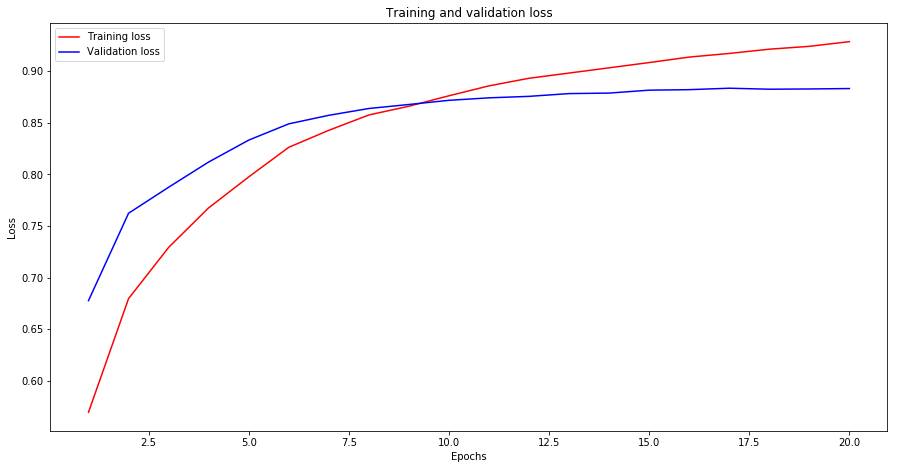

In [53]:
fig = plt.figure(figsize=(15,7.5))

epochs = range(1, len(history.history['acc']) + 1)

plt.plot(epochs, history.history['acc'], 'r', label='Training loss')
plt.plot(epochs, history.history['val_acc'], 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()